In [1]:
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt, csv, json
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')  # 또는 'retina'

In [2]:
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

print("backend =", plt.get_backend())

torch: 2.8.0+cpu
cuda available: False
backend = inline


# Model
- CLIP 모델/프로세서 로드: ViT-B/32 백본의 CLIP을 불러와 평가 모드로 올림.
- processor는 이미지 리사이즈/정규화, 토큰화 등 전처리를 자동 수행(기본 224×224).

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(MODEL_ID).to(device).eval()
processor = CLIPProcessor.from_pretrained(MODEL_ID)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Data 준비

In [4]:
DATA = Path("/workspace/data/images")
OUT  = Path("/workspace/out"); OUT.mkdir(parents=True, exist_ok=True)
imgs = sorted([p for p in DATA.glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])[:10]
assert imgs, "Put ~10 images into /workspace/data/images first."

In [5]:
imgs

[PosixPath('/workspace/data/images/alora-griffiths-KKZmUQjTO2E-unsplash.jpg'),
 PosixPath('/workspace/data/images/benjamin-voros-TnNo84AJJ5A-unsplash.jpg'),
 PosixPath('/workspace/data/images/brando-makes-branding-bimk08qJzIY-unsplash.jpg'),
 PosixPath('/workspace/data/images/celine-ruiz-rr4bawLxOjc-unsplash.jpg'),
 PosixPath('/workspace/data/images/engin-akyurt-5raPrOhbKQo-unsplash.jpg'),
 PosixPath('/workspace/data/images/mahdi-bafande-npyWFYpHQ94-unsplash.jpg'),
 PosixPath('/workspace/data/images/michael-c-zVycYmcblDY-unsplash.jpg'),
 PosixPath('/workspace/data/images/nimble-made-hMMXhKSZk7k-unsplash.jpg'),
 PosixPath('/workspace/data/images/redd-francisco-jC7nVH_Sw8k-unsplash.jpg'),
 PosixPath('/workspace/data/images/swello-XTHoccgohqQ-unsplash.jpg')]

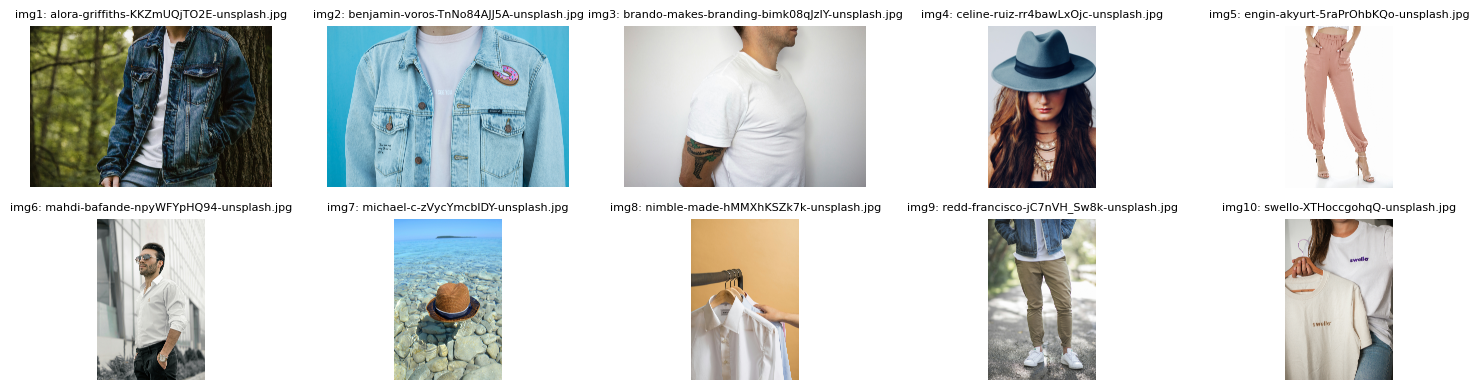

In [6]:
thumbs = [Image.open(p).convert("RGB") for p in imgs]
cols = 5; rows = (len(thumbs)+cols-1)//cols
plt.figure(figsize=(cols*3, rows*2))
for i, im in enumerate(thumbs, 1):
    ax = plt.subplot(rows, cols, i); ax.imshow(im); ax.axis("off")
    ax.set_title(f"img{i}: {imgs[i-1].name}", fontsize=8)
plt.tight_layout()
plt.show()

In [7]:
CATEGORIES = {
    "white_dress_shirt": [
        "a photo of a white dress shirt", "a white button-up shirt", "a white long-sleeve shirt"
    ],
    "hat": [
        "a photo of a baseball cap", "a photo of a hat", "a black cap"
    ],
    "denim_shirt": [
        "a photo of a denim shirt", "a blue denim shirt"
    ],
    "jeans": [
        "a photo of blue jeans", "a photo of denim pants"
    ],
    "white_tshirt": [
        "a photo of a white t-shirt", "a plain white tee"
    ],
    "pants" : [
        "a photo of a pants", 
    ]
}


# 실습
## 이미지→카테고리 매칭 코드 설명 (CLIP, ViT-B/32)

아래 코드는 이미지 10장과 카테고리별 텍스트 동의어를 CLIP의 공통 임베딩 공간으로 투영한 뒤,
이미지마다 Top-3 카테고리를 예측하는 파이프라인

### 목적

- 이미지와 텍스트(카테고리 설명)를 같은 차원 𝐷 의 임베딩으로 변환
- 임베딩을 L2 정규화하여 내적 = 코사인 유사도
- 카테고리마다 여러 표현(동의어)을 평균해 프로토타입 임베딩 생성
- 각 이미지가 어떤 카테고리에 가장 가까운지 Top-K 매칭 산출

### 입력/출력 개념

#### 입력
- $\texttt{imgs}$: 이미지 경로 리스트 $(N\ \text{장})$
- $\texttt{CATEGORIES}$: $\{\ \text{카테고리명} : [\text{동의어 문장들}]\ \}$ $(K\ \text{개})$

#### 출력 (주요 변수)
- $\mathbf{F}_{\text{img}} \in \mathbb{R}^{N \times D}$: 이미지 임베딩 *(정규화)*
- $\mathbf{F}_{\text{txt}}^{\text{proto}} \in \mathbb{R}^{K \times D}$: 카테고리 **프로토타입** 임베딩 *(정규화)*
- $\mathbf{S}_{\text{ic}} = \mathbf{F}_{\text{img}}\ \mathbf{F}_{\text{txt}}^{\text{proto}\top} \in \mathbb{R}^{N \times K}$: 이미지–카테고리 **코사인 유사도** 행렬
- $\texttt{mapping}$: 각 이미지의 **Top-3 카테고리**와 유사도 점수 리스트

> 보통 $D=512$. 예: $N=10$, $K=5$ 이면  
> $\mathbf{F}_{\text{img}} \in \mathbb{R}^{10 \times 512}$, $\mathbf{F}_{\text{txt}}^{\text{proto}} \in \mathbb{R}^{5 \times 512}$, $\mathbf{S}_{\text{ic}} \in \mathbb{R}^{10 \times 5}$.


In [8]:
# === 3) 임베딩 ===
@torch.no_grad()
def get_image_features(paths):
    ims=[Image.open(p).convert("RGB") for p in paths]
    x=processor(images=ims, return_tensors="pt").to(device)
    f=model.get_image_features(**x); f=f/f.norm(dim=-1, keepdim=True)
    return f

@torch.no_grad()
def text_feats(texts):
    x=processor(text=texts, return_tensors="pt", padding=True, truncation=True).to(device)
    f=model.get_text_features(**x); f=f/f.norm(dim=-1, keepdim=True)
    return f

1. get_image_features(...)로 이미지 임베딩 $\mathbf{F}_{\text{img}} \in \mathbb{R}^{N\times D}$ 추출

2. text_feats(...)로 텍스트 임베딩을 뽑고, 동의어 평균으로 카테고리 프로토타입 $\mathbf{F}_{\text{txt}}^{\text{proto}} \in \mathbb{R}^{K\times D} $ 생성

3. 둘 다 L2 정규화 → 내적이 코사인 유사도랑 같아짐

4. 유사도 행렬 $\mathbf{S}_{\text{ic}} = \mathbf{F}_{\text{img}}\ \mathbf{F}_{\text{txt}}^{\text{proto}\top} \in \mathbb{R}^{N\times K} $ 계산

5. 각 이미지별로 Top-K 카테고리(예: Top-3) 뽑아서 mapping에 저장

In [9]:
F_img = get_image_features(imgs)

# 카테고리별 텍스트 프로토타입(동의어 평균)
cat_names = list(CATEGORIES.keys())
proto = []
for name in cat_names:
    F_t = text_feats(CATEGORIES[name])
    proto.append(F_t.mean(dim=0, keepdim=True))
F_txt_proto = torch.cat(proto, dim=0)              # [K, D]
F_txt_proto = F_txt_proto / F_txt_proto.norm(dim=-1, keepdim=True)

# === 4) 이미지→카테고리 매칭 (Top-3) ===
S_ic = (F_img @ F_txt_proto.T).cpu().numpy()       # [N_img, K]
idx_top = np.argsort(-S_ic, axis=1)[:, :3]

mapping = []
for i in range(len(imgs)):
    top3 = [(cat_names[j], float(S_ic[i, j])) for j in idx_top[i]]
    mapping.append({
        "image_idx": i+1, "image_file": imgs[i].name,
        "pred1": top3[0][0], "score1": round(top3[0][1], 4),
        "pred2": top3[1][0], "score2": round(top3[1][1], 4),
        "pred3": top3[2][0], "score3": round(top3[2][1], 4),
    })

In [10]:
print("F_img:", F_img.shape, "F_txt_proto:", F_txt_proto.shape, "S_ic:", S_ic.shape)
for i in range(len(imgs)):
    j = S_ic[i].argmax()
    print(f"img{i+1} ({imgs[i].name}) → {cat_names[j]}  score={S_ic[i,j]:.3f}")

F_img: torch.Size([10, 512]) F_txt_proto: torch.Size([6, 512]) S_ic: (10, 6)
img1 (alora-griffiths-KKZmUQjTO2E-unsplash.jpg) → denim_shirt  score=0.297
img2 (benjamin-voros-TnNo84AJJ5A-unsplash.jpg) → denim_shirt  score=0.296
img3 (brando-makes-branding-bimk08qJzIY-unsplash.jpg) → white_tshirt  score=0.314
img4 (celine-ruiz-rr4bawLxOjc-unsplash.jpg) → hat  score=0.249
img5 (engin-akyurt-5raPrOhbKQo-unsplash.jpg) → pants  score=0.258
img6 (mahdi-bafande-npyWFYpHQ94-unsplash.jpg) → white_dress_shirt  score=0.301
img7 (michael-c-zVycYmcblDY-unsplash.jpg) → hat  score=0.275
img8 (nimble-made-hMMXhKSZk7k-unsplash.jpg) → white_dress_shirt  score=0.301
img9 (redd-francisco-jC7nVH_Sw8k-unsplash.jpg) → pants  score=0.282
img10 (swello-XTHoccgohqQ-unsplash.jpg) → white_tshirt  score=0.266


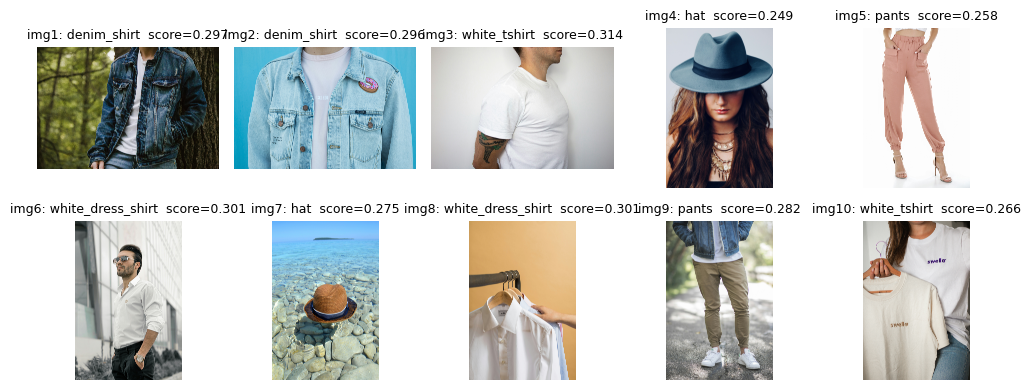

In [11]:
# top-1 카테고리와 점수 한 번에 구하기
pred_top1 = S_ic.argmax(axis=1)   # shape: (N,)
score_top1 = S_ic.max(axis=1)     # shape: (N,)

cols = 5
rows = (len(thumbs) + cols - 1) // cols
plt.figure(figsize=(cols*2, rows*2))

for i, (im, pred, sc) in enumerate(zip(thumbs, pred_top1, score_top1), start=1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(im); ax.axis("off")
    ax.set_title(f"img{i}: {cat_names[int(pred)]}  score={float(sc):.3f}", fontsize=9)

plt.tight_layout()
plt.savefig(OUT / "thumbs_pred_top1.png", dpi=160)
plt.show()


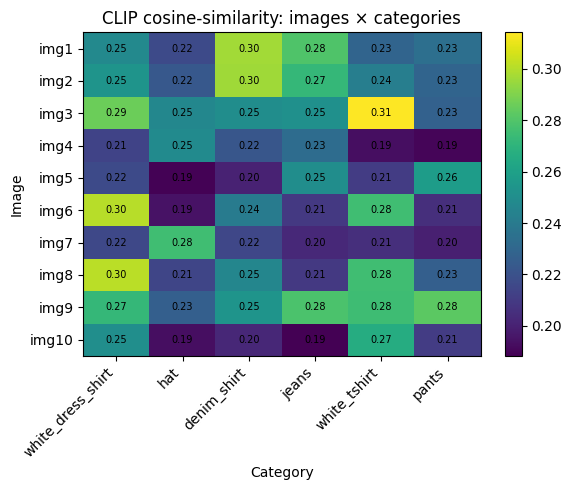

In [12]:
fig = plt.figure(figsize=(max(6, 0.9*len(cat_names)), max(4, 0.5*len(imgs))))
ax = plt.gca()
im = ax.imshow(S_ic, aspect="auto")
plt.title("CLIP cosine-similarity: images × categories")
plt.xlabel("Category"); plt.ylabel("Image")
plt.colorbar(im)

plt.xticks(range(len(cat_names)), cat_names, rotation=45, ha="right")
plt.yticks(range(len(imgs)), [f"img{i+1}" for i in range(len(imgs))])

# 값 오버레이 (작을 때만)
if S_ic.size <= 200:
    for i in range(S_ic.shape[0]):
        for j in range(S_ic.shape[1]):
            ax.text(j, i, f"{S_ic[i,j]:.2f}", ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.savefig(OUT / "clip_heatmap_ic_annot.png", dpi=160)
plt.show()


### 의문점 : 텍스트 임베딩, 이미지 임베딩 각각 추출해서 dot-product 로 계산해야 되는건가

[찾아본 결과]

CLIP은 이미지와 텍스트를 동시에 넣으면 내부에서 정규화된 임베딩의 내적에 **learned temperature(= logit_scale)**를 곱해 **유사도(logits)**를 바로 반환
- 그렇지만 실무/프로젝트에서는 “각자 임베딩 → dot-product” 방식이 정석
1. 캐싱/재사용: 카탈로그(수천~수백만 이미지) 임베딩은 미리 뽑아 저장, 질의 텍스트만 임베딩해서 빠르게 검색.

2. 확장성: 대량 검색은 행렬 곱/ANN(FAISS, ScaNN)로 스케일아웃.

3. 유연성: temperature 조절, 임계값, re-ranking, 프로토타입 평균(동의어 평균) 같은 커스텀 로직 적용이 쉬움.

4. 비동기 파이프라인: 이미지 쪽/텍스트 쪽을 분리 운영 가능(서비스 구조에 유리).

설계적으로 CLIP은 ‘두 타워(two-tower)’ 구조라서, 모달리티 간 교차 주의(cross-attention) 없이 공통 공간에서의 코사인 유사도가 최종 점수
즉, “임베딩 → 내적”이 모델 설계 자체의 핵심이에요. 우리가 바깥에서 dot-product를 하는 게 훈련 시 점수 계산과 동일한 원리